# Cryptomarket Predicator
#### Predict BTC-(altcoin) using Recurrent Neural Network RNN

In [1]:
# Currency use in comparison to Bitcoin.
currency = 'POWR'

In [2]:
# Dependencies
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Read & Process data

In [3]:
dataset = pd.read_csv('../input/BTC'+currency+'_techIndicators.csv')
dataset.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
0,0.000036,0.000036,-1.308299e-08,23.157895,1.000000e-08
1,0.000036,0.000036,-6.009042e-09,36.666667,1.000000e-08


In [4]:
### Normalisation

In [5]:
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
0,-0.01976,-0.001486,-0.001811,-0.287575,-0.000767
1,-0.01976,-0.001482,-0.001395,-0.152487,-0.000767


### Hyperparams

In [6]:
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 1986
The current configuration gives us 662 batches of 1 observations each one looking 3 steps in the past


### Train-Test split

In [7]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]

for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [8]:
datasetTrain.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
0,-0.01976,-0.001486,-0.001811,-0.287575,-0.000767
1,-0.01976,-0.001482,-0.001395,-0.152487,-0.000767


In [9]:
datasetTest.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
1884,-0.043477,-0.002663,-0.006685,0.019308,-0.000510
1885,-0.043397,-0.002655,-0.003974,0.027855,-0.000567


In [10]:
xTrain = datasetTrain[['Price','MACD','Stochastics','ATR']].as_matrix()
yTrain = datasetTrain['PriceTarget'].as_matrix()

In [11]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[-0.01975997 -0.00181098 -0.28757474 -0.00076745]
 [-0.01975997 -0.00139513 -0.15248702 -0.00076745]
 [-0.0196793  -0.00104883 -0.13582036 -0.00071845]] 
 [-0.00148608 -0.00148206 -0.00148206]


In [12]:
xTest = datasetTest[['Price','MACD','Stochastics','ATR']].as_matrix()
yTest = datasetTest['PriceTarget'].as_matrix()

In [13]:
print(xTest[0:3],'\n',yTest[0:3])

[[-0.0434773  -0.00668549  0.01930785 -0.00051022]
 [-0.04339663 -0.00397388  0.02785486 -0.00056738]
 [-0.04323529 -0.00168649  0.12162301 -0.00068579]] 
 [-0.00266281 -0.00265478 -0.00260257]


## Visualise starting price data

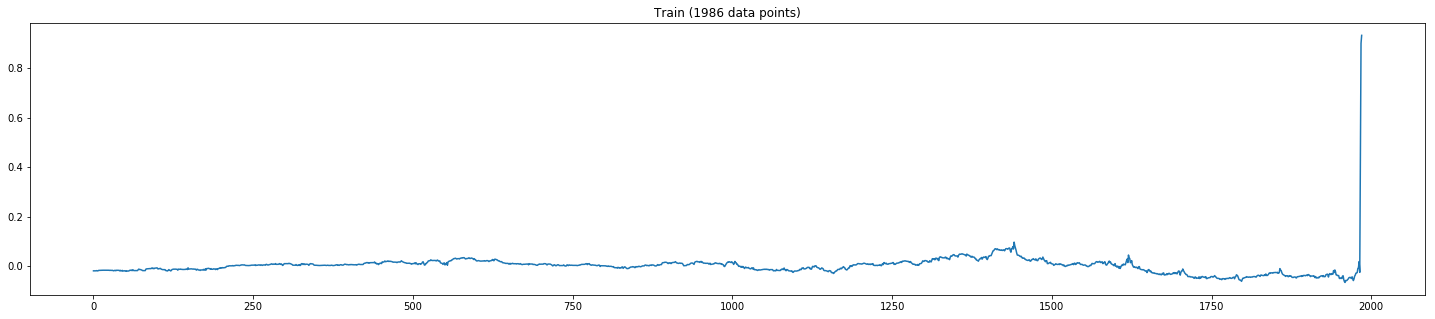

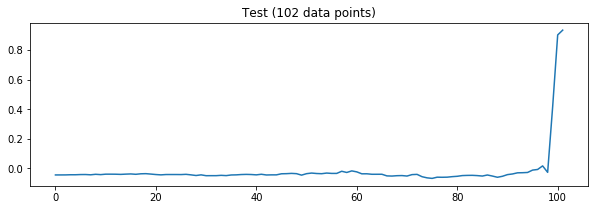

In [14]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders
A `placeholder` is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data. In TensorFlow terminology, we then feed data into the graph through these placeholders.

In [15]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Weights and biases are the learnable parameters of your model. As well as neural networks, they appear with the same names in related models such as linear regression. Most machine learning algorithms include some learnable parameters like this.

Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

A TensorFlow `variable` is the best way to represent shared, persistent state manipulated by your program.

Variables are manipulated via the tf.Variable class. A `tf.Variable` represents a tensor whose value can be changed by running ops on it. Unlike tf.Tensor objects, a tf.Variable exists outside the context of a single session.run call.

Internally, a `tf.Variable` stores a persistent tensor. Specific ops allow you to read and modify the values of this tensor. These modifications are visible across multiple tf.Sessions, so multiple workers can see the same values for a tf.Variable.

Besides placeholders, variables are another cornerstone of the TensorFlow universe. While placeholders are used to store input and target data in the graph, variables are used as flexible containers within the graph that are allowed to change during graph execution. Weights and biases are represented as variables in order to adapt during training. Variables need to be initialized, prior to model training.

In [16]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

#### Unpack

In [17]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass

In [18]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

states_series = tf.transpose(states_series,[1,0,2])

## Backward pass

In [19]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weight and bias

In [20]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss, Optimaser

In [21]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

### Cost function
The cost function of the network is used to generate a measure of deviation between the network’s predictions and the actual observed training targets. For regression problems, the mean squared error (MSE) function is commonly used. MSE computes the average squared deviation between predictions and targets. Basically, any differentiable function can be implemented in order to compute a deviation measure between predictions and targets.

However, the MSE exhibits certain properties that are advantageous for the general optimization problem to be solved.

In [22]:
# Cost function
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))



### Optimiser
The optimizer takes care of the necessary computations that are used to adapt the network’s weight and bias variables during training. Those computations invoke the calculation of so called gradients, that indicate the direction in which the weights and biases have to be changed during training in order to minimize the network’s cost function. The development of stable and speedy optimizers is a major field in neural network an deep learning research.

In [23]:
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Here the Adam Optimizer is used, which is one of the current default optimizers in deep learning development. Adam stands for “Adaptive Moment Estimation” and can be considered as a combination between two other popular optimizers AdaGrad and RMSProp.

### Initializers
Initializers are used to initialize the network’s variables before training. Since neural networks are trained using numerical optimization techniques, the starting point of the optimization problem is one the key factors to find good solutions to the underlying problem. There are different initializers available in TensorFlow, each with different initialization approaches. Here, I use the `tf.global_variables_initializer()`, which is just a shortcut for `variables_initializer(global_variables())`.

### Fitting the neural network
After having defined the placeholders, variables, initializers, cost functions and optimizers of the network, the model needs to be trained. Usually, this is done by minibatch training. During minibatch training random data samples of `num_batches` are drawn from the training data and fed into the network. The training dataset gets divided into `batch_idx / num_batches` batches that are sequentially fed into the network. At this point the placeholders `batchX` and `batchY` come into play. They store the input and target data and present them to the network as inputs and targets.

A sampled data batch of `batchX` flows through the network until it reaches the output layer. There, TensorFlow compares the models predictions against the actual observed targets `batchY` in the current batch. Afterwards, TensorFlow conducts an optimization step and updates the networks parameters, corresponding to the selected learning scheme. After having updated the **weights** and **biases**, the next batch is sampled and the process repeats itself. The procedure continues until all batches have been presented to the network. One full sweep over all batches is called an **epoch**.

The training of the network stops once the maximum number of epochs is reached or another stopping criterion defined by the user applies.

In [24]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 200 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.006390
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000295
Step 600 - Loss: 0.000496
Epoch 1
Step 0 - Loss: 0.005391
Step 200 - Loss: 0.000398
Step 400 - Loss: 0.000002
Step 600 - Loss: 0.001157
Epoch 2
Step 0 - Loss: 0.016574
Step 200 - Loss: 0.000015
Step 400 - Loss: 0.000070
Step 600 - Loss: 0.000535
Epoch 3
Step 0 - Loss: 0.000084
Step 200 - Loss: 0.000105
Step 400 - Loss: 0.000333
Step 600 - Loss: 0.000025
Epoch 4
Step 0 - Loss: 0.002917
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000058
Step 600 - Loss: 0.000105
Epoch 5
Step 0 - Loss: 0.000701
Step 200 - Loss: 0.000166
Step 400 - Loss: 0.000110
Step 600 - Loss: 0.000083
Epoch 6
Step 0 - Loss: 0.004826
Step 200 - Loss: 0.000002
Step 400 - Loss: 0.000023
Step 600 - Loss: 0.000079
Epoch 7
Step 0 - Loss: 0.000618
Step 200 - Loss: 0.000155
Step 400 - Loss: 0.000117
Step 600 - Loss: 0.000016
Epoch 8
Step 0 - Loss: 0.004181
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000021
Step 600 - Loss: 0.000015
Epoch 9
St

Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000000
Step 600 - Loss: 0.000029
Epoch 75
Step 0 - Loss: 0.000024
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000009
Step 600 - Loss: 0.000004
Epoch 76
Step 0 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000000
Step 600 - Loss: 0.000023
Epoch 77
Step 0 - Loss: 0.000025
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000009
Step 600 - Loss: 0.000002
Epoch 78
Step 0 - Loss: 0.000001
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000000
Step 600 - Loss: 0.000037
Epoch 79
Step 0 - Loss: 0.000018
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000010
Step 600 - Loss: 0.000004
Epoch 80
Step 0 - Loss: 0.000003
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000000
Step 600 - Loss: 0.000025
Epoch 81
Step 0 - Loss: 0.000020
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000008
Step 600 - Loss: 0.000005
Epoch 82
Step 0 - Loss: 0.000001
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000002
Step 600 - Loss: 0.000037
Epoch 83
Step 0 - Loss: 0.000018
S

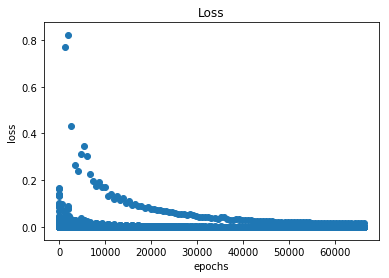

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

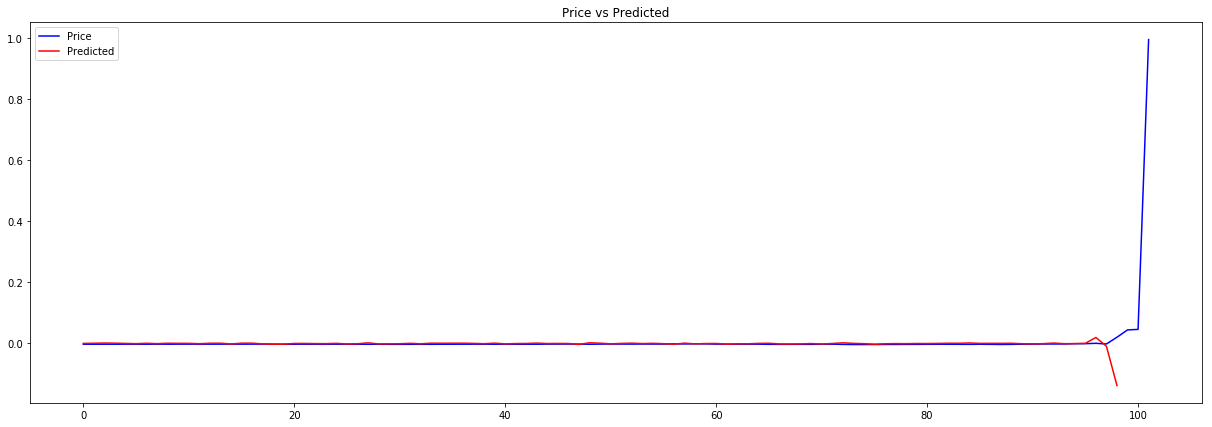

In [26]:

plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.savefig('../result/BTC-'+currency+'-PriceVsPrediction.png')
plt.show()

## References
- [Siraj Raval - Youtube - Quantum Computing - The Math of Intelligence #10](https://www.youtube.com/watch?v=LhtnECml-KI)
- [SirajsCodingChallenges by Alberto Blanco Garcés](https://github.com/alberduris/SirajsCodingChallenges)
- [A simple deep learning model for stock price prediction using TensorFlow](https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877)